In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_profiling as pdp
import sys
import urllib.request
import warnings
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AR, ARResults
from tqdm import tqdm
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)
sys.path.insert(0, '../utils/')
from utils import *
%matplotlib inline

In [2]:
start("avocado")

DATE: 2019-05-30 16:03:48.615430
FILE: avocado
PID: 6276
HOST: Y-project-11
ENV: Windows-10-10.0.17134-SP0


In [3]:
data_url = "avocado.csv"
base_name = os.path.basename(data_url)
with timer("read"):
    file_path = os.path.join("../data/input", base_name)
    df = pd.read_csv(file_path, index_col="Unnamed: 0", encoding="utf-8")

[read] start
[read] done in 0 s


In [4]:
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [5]:
# 前処理
# date 列を datetime 型に変更
df["Date"] = pd.to_datetime(df["Date"])

In [6]:
df.shape

(18249, 13)

In [7]:
df.dtypes

Date            datetime64[ns]
AveragePrice           float64
Total Volume           float64
4046                   float64
4225                   float64
4770                   float64
Total Bags             float64
Small Bags             float64
Large Bags             float64
XLarge Bags            float64
type                    object
year                     int64
region                  object
dtype: object

In [8]:
pdp.ProfileReport(df)

Number of variables,14
Number of observations,18249
Total Missing (%),0.0%
Total size in memory,1.9 MiB
Average record size in memory,112.0 B
Numeric,6
Categorical,2
Date,1
Text (Unique),0
Rejected,5
Correlation,0.97786


In [9]:
df.describe()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


In [10]:
df_cal_conv = df[(df["region"]=="California")&(df["type"]=="conventional")]
df_cal_conv = df_cal_conv.sort_values(by='Date')
df_cal_conv = df_cal_conv.reset_index()

In [11]:
df_cal_conv.head(20)

,index,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,51,2015-01-04,0.93,5777334.90,2843648.26,2267755.26,137479.64,528451.74,477193.38,47882.56,3375.80,conventional,2015,California
1,50,2015-01-11,0.92,6024932.34,2889591.29,2485720.10,103573.42,546047.53,510560.41,31874.03,3613.09,conventional,2015,California
2,49,2015-01-18,1.02,5570915.26,2780859.66,2108450.36,121614.31,559990.93,520299.26,36501.18,3190.49,conventional,2015,California
3,48,2015-01-25,1.06,4929884.26,2380955.61,1827783.28,150535.50,570609.87,521004.15,46809.48,2796.24,conventional,2015,California
4,47,2015-02-01,0.85,9032180.67,4794142.14,3460743.80,177145.49,600149.24,556205.20,41203.20,2740.84,conventional,2015,California
5,46,2015-02-08,0.91,5871224.58,2908845.38,2200393.89,149458.93,612526.38,553682.71,56311.08,2532.59,conventional,2015,California
6,45,2015-02-15,0.96,5699944.93,3315163.60,1620462.13,169907.54,594411.66,544990.68,47017.93,2403.05,conventional,2015,California
7,44,2015-02-22,0.96,5951871.32,3210177.22,1933699.49,172675.88,635318.73,596184.90,36940.51,2193.32,conventional,2015,California
8,43,2015-03-01,0.84,6700134.25,3516551.29,2460932.41,170580.54,552070.01,515386.40,34845.51,1838.10,conventional,2015,California
9,42,2015-03-08,0.96,5990243.89,3484274.60,1649936.05,184720.58,671312.66,642307.00,27241.05,1764.61,conventional,2015,California


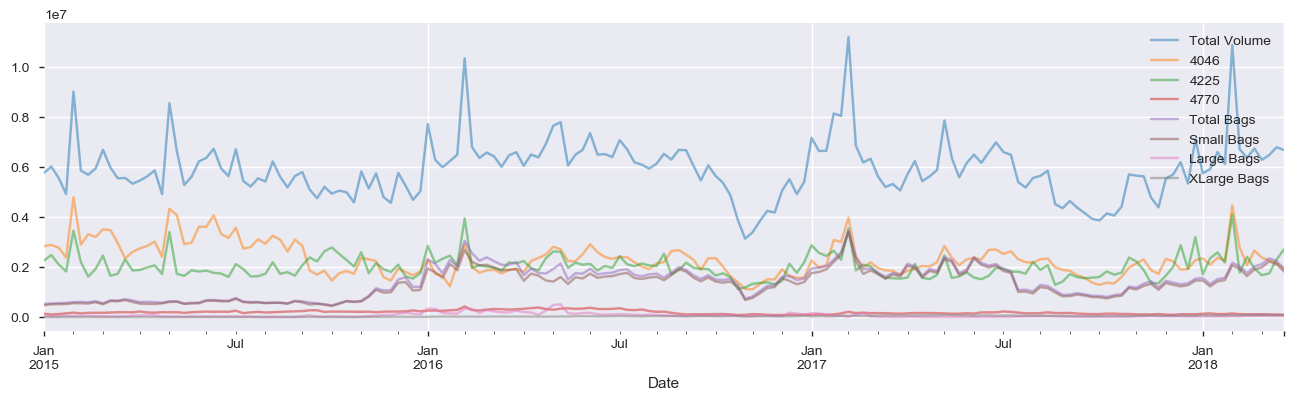

In [12]:
df_cal_conv.plot(x="Date", y=["Total Volume","4046","4225","4770","Total Bags","Small Bags","Large Bags","XLarge Bags"], figsize=(16,4), alpha=.5)
plt.show()

## Moving Average

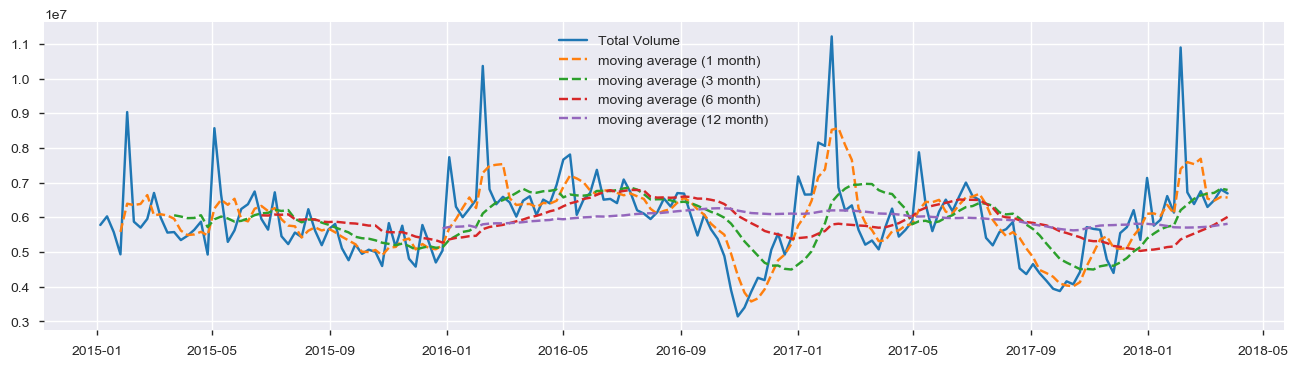

In [13]:
x = df_cal_conv["Date"]
y  = df_cal_conv["Total Volume"]
y1  = df_cal_conv["Total Volume"].rolling(4).mean()  # 1か月
y3 = df_cal_conv["Total Volume"].rolling(12).mean()  # 3か月
y6 = df_cal_conv["Total Volume"].rolling(25).mean()  # 6か月
y12 = df_cal_conv["Total Volume"].rolling(52).mean() # 12か月
plt.figure(figsize=(16,4))
plt.plot(x, y, ls="-", label="Total Volume")
plt.plot(x, y1, ls="--", label="moving average (1 month)")
plt.plot(x, y3, ls="--", label="moving average (3 month)")
plt.plot(x, y6, ls="--", label="moving average (6 month)")
plt.plot(x, y12, ls="--", label="moving average (12 month)")
plt.legend()
plt.show()

In [14]:
df_cal_conv["Total Volume"].tail()

164    6750361.46
165    6295529.61
166    6488605.43
167    6802084.11
168    6687009.44
Name: Total Volume, dtype: float64

## Auto Regression

In [15]:
# build
ar = AR(df_cal_conv["Total Volume"])
# select order
order = ar.select_order(maxlag=12, ic="aic")
print(order)
# fit
ar = ar.fit(maxlag=order, ic="aic")
# predict
ar_predict = ar.predict(168, 190, dynamic=True)

7


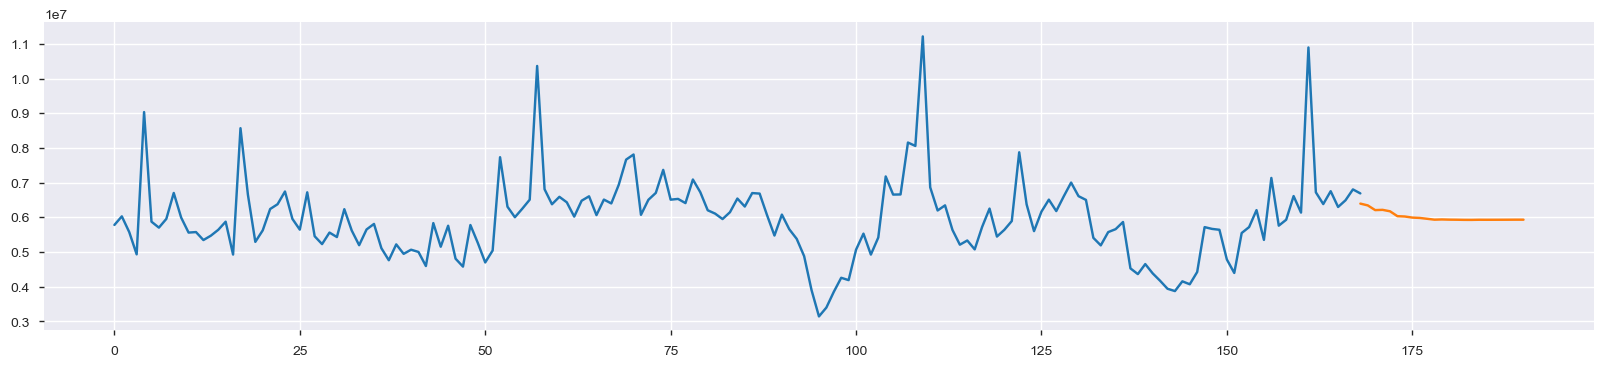

In [16]:
x = df_cal_conv.index
y = df_cal_conv["Total Volume"]
x_pred = ar_predict.index
y_pred = ar_predict
plt.figure(figsize=(20, 4))
plt.plot(x, y)
plt.plot(x_pred, y_pred)
plt.show()

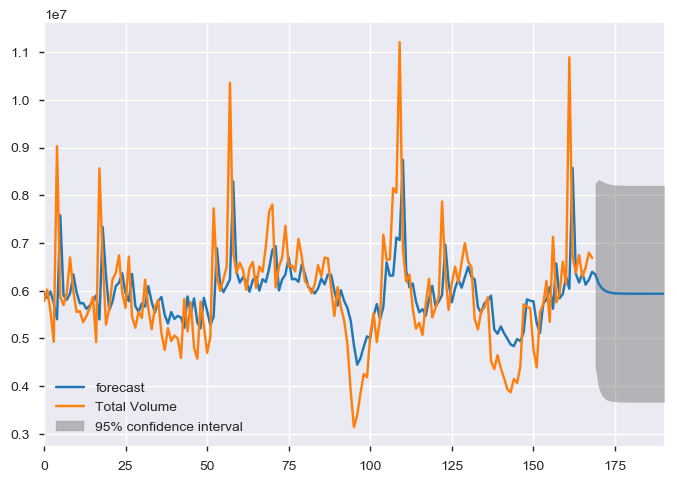

In [17]:
# もしくは ARMA の移動平均の次数を0に設定
from statsmodels.tsa.arima_model import ARMA
arma = ARMA(df_cal_conv["Total Volume"], order=(1,0))
res = arma.fit()
res.plot_predict(0, 190)
plt.show()

In [18]:
end()

ELAPSED: 4.60 (sec)
